# Q3: Study the Neural Collapse phenomenon


## Setup

In [ ]:
# Mount Google Drive (for saving checkpoints)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clone repository
import os
if not os.path.exists('/content/OOD-Detection-Project---CSC_5IA23'):
    !git clone https://github.com/DiegoFleury/OOD-Detection-Project---CSC_5IA23/
%cd /content/OOD-Detection-Project---CSC_5IA23

Cloning into 'OOD-Detection-Project---CSC_5IA23'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 193 (delta 85), reused 156 (delta 55), pack-reused 0 (from 0)
Receiving objects: 100% (193/193), 3.13 MiB | 30.51 MiB/s, done.
Resolving deltas: 100% (85/85), done.
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
/content/OOD-Detection-Project---CSC_5IA23


In [ ]:
# Install dependencies
!pip install -q torch torchvision matplotlib seaborn scikit-learn pyyaml imageio tqdm

In [ ]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml

from src.models import ResNet18
from src.data import get_cifar100_loaders
from src.utils import Trainer, plot_training_curves, create_training_gif

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [ ]:
# Load config
with open('configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration:")
print(yaml.dump(config, default_flow_style=False))

Configuration:
data:
  augment: true
  data_dir: ./data
  num_workers: 2
device: cuda
model:
  num_classes: 100
ood:
  datasets:
  - SVHN
  - CIFAR10
  - Textures
  sampling_ratio: 0.1
  tpt_mask:
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 1
  - 1
  - 1
  - 1
paths:
  checkpoints: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints
  figures: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures
  gifs: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/gifs
  metrics: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics
  ood_detection: /content/drive/MyDrive/Colab Notebooks/OOD/Results/ood_scoring
  results: /content/drive/MyDrive/Colab Notebooks/OOD/Results
  tables: /content/drive/MyDrive/Colab Notebooks/OOD/Results/tables
training:
  batch_size: 128
  checkpoint_frequency: 25
  early_stopping_patience: 999
  epochs: 300
  lr: 0.1
  momentum: 0.9
  val_split: 0.1
  weight_decay: 0.0005



## 1. Load Data

In [ ]:
print("Loading CIFAR-100 dataset...")

train_loader, val_loader, test_loader = get_cifar100_loaders(
    data_dir=config['data']['data_dir'],
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    augment=config['data']['augment'],
    val_split=config['training']['val_split']
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading CIFAR-100 dataset...


100%|██████████| 169M/169M [00:03<00:00, 48.5MB/s]


Train batches: 352
Val batches: 40
Test batches: 79


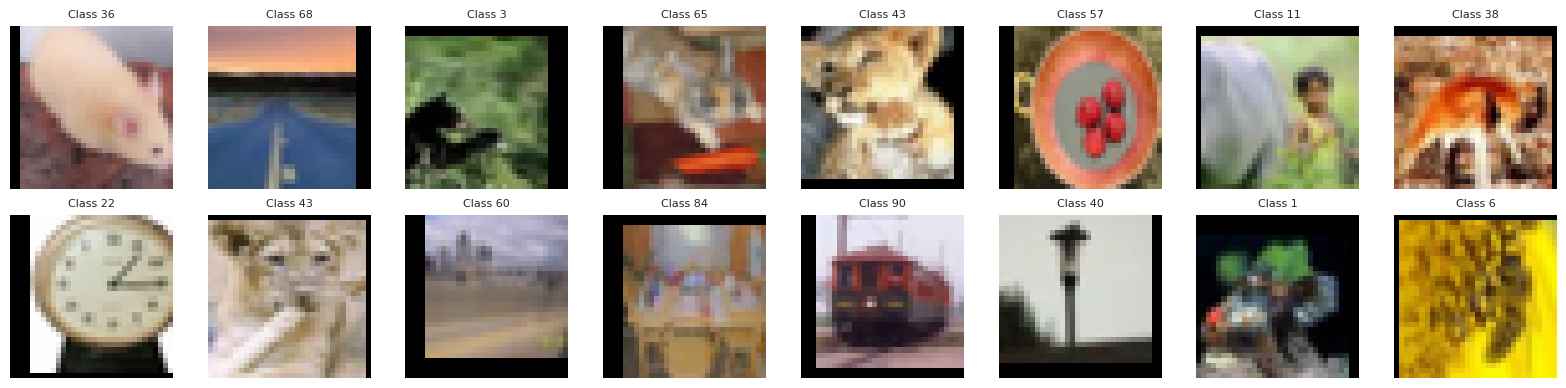

In [ ]:
# Visualize sample batch
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()
    # Denormalize
    img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Class {labels[i].item()}", fontsize=8)

plt.tight_layout()

sample_batch_path = os.path.join(config['paths']['figures'], 'training', 'sample_batch.png')
plt.savefig(sample_batch_path, dpi=150, bbox_inches='tight')
plt.show()

## 2. Create Model

In [ ]:
print("Creating ResNet-18 model...")

model = ResNet18(num_classes=config['model']['num_classes'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
x_test = torch.randn(2, 3, 32, 32)
with torch.no_grad():
    out = model(x_test)
print(f"Output shape: {out.shape}")

Creating ResNet-18 model...
Total parameters: 11,220,132
Trainable parameters: 11,220,132
Output shape: torch.Size([2, 100])


## 3. Train Model

In [ ]:
# 3. Train or resume from checkpoint
import glob
import re
import os

checkpoint_dir = config['paths']['checkpoints']
print(checkpoint_dir)
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))
print(checkpoints)
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=config['training']['lr'],
    momentum=config['training']['momentum'],
    weight_decay=config['training']['weight_decay'],
    device=device
)

if checkpoints:
    # Extract epoch number from checkpoint filename
    def get_epoch_num(path):
        match = re.search(r'epoch(\d+)', path)
        if match:
            return int(match.group(1))
        return 0

    # Get checkpoint with highest epoch number
    latest = max(checkpoints, key=get_epoch_num)
    epoch_num = get_epoch_num(latest)

    print(f"Resuming from: {os.path.basename(latest)} (epoch {epoch_num})")
    trainer.load_checkpoint(latest)

    epochs_done = len(trainer.history.get('train_loss', []))
    epochs_left = max(0, config['training']['epochs'] - epochs_done)
    print(f"Epoch {epochs_done}/{config['training']['epochs']} | Best val: {trainer.best_val_acc:.2f}%")
else:
    print("Starting fresh training")
    epochs_left = config['training']['epochs']

if epochs_left > 0:
    history = trainer.train(
        epochs=epochs_left,
        save_dir=checkpoint_dir,
        early_stopping_patience=config['training']['early_stopping_patience'],
        checkpoint_frequency=config['training']['checkpoint_frequency']
    )
else:
    print("Already trained!")
    history = trainer.history

print("\n" + "="*50)
print("Training finished!")
print("="*50)


/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints
['/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch175.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch25.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch50.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch75.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch100.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch125.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch150.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch200.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch225.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resne

In [ ]:
import sys
import os

from src.neural_collapse.nc_analysis import (
    load_checkpoints_and_analyze,
    plot_nc_evolution,
    plot_nc_individual,
    save_metrics_yaml,
    NCMetricsTracker
)


print("NC analysis module imported.")

checkpoint_dir = config['paths']['checkpoints']
figures_dir = os.path.join(config['paths']['figures'], 'neural_collapse')
metrics_dir = config['paths']['metrics']

import glob
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))
print(f"Checkpoints found: {len(checkpoints)}")
for ckpt in sorted(checkpoints)[:5]:
    print(f"   - {os.path.basename(ckpt)}")
if len(checkpoints) > 5:
    print(f"   ... and {len(checkpoints) - 5} more")

print("Running Neural Collapse analysis...")
print(f"   Device: {device}")
print(f"   Classes: {config['model']['num_classes']}")
print()


tracker = load_checkpoints_and_analyze(
    checkpoint_dir=checkpoint_dir,
    model_class=ResNet18,
    loader=train_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    checkpoint_pattern='resnet18_cifar100_*.pth',
    epoch_regex=r'epoch(\d+)',
    verbose=True
)

print("\n" + tracker.summary())

os.makedirs(figures_dir, exist_ok=True)

fig = plot_nc_evolution(tracker, save_dir=figures_dir)
plt.show()

individual_figs = plot_nc_individual(tracker, save_dir=figures_dir)
print(f"{len(individual_figs)} individual figures generated")

os.makedirs(metrics_dir, exist_ok=True)

yaml_path = os.path.join(metrics_dir, 'nc_evolution_metrics.yaml')
save_metrics_yaml(tracker, yaml_path)

# Also save as JSON
import json
json_path = os.path.join(metrics_dir, 'nc_evolution_metrics.json')
metrics_dict = tracker.to_dict()

# Convert NaN to None (JSON does not support NaN)
for key, values in metrics_dict.items():
    if isinstance(values, list):
        metrics_dict[key] = [
            v if not (isinstance(v, float) and np.isnan(v)) else None
            for v in values
        ]

with open(json_path, 'w') as f:
    json.dump(metrics_dict, f, indent=2)
print(f"Metrics saved to JSON: {json_path}")

# %% Cell 7: Identify Terminal Phase of Neural Collapse
# ------------------------------------------------------------------------------
# Neural Collapse typically occurs in the "terminal phase of training"
# when the model reaches ~0% training error

print("\n" + "="*60)
print("NEURAL COLLAPSE PHASE ANALYSIS")
print("="*60)

# Find when accuracy > 99%
terminal_phase_idx = None
for i, acc in enumerate(tracker.accuracy):
    if acc > 0.99:
        terminal_phase_idx = i
        break

if terminal_phase_idx is not None:
    print(f"\nTerminal Phase detected at epoch {tracker.epochs[terminal_phase_idx]}")
    print(f"   (accuracy > 99%)")
    print()
    print("NC metrics at the start of the Terminal Phase:")
    print(f"   NC1 (Sw/Sb): {tracker.Sw_invSb[terminal_phase_idx]:.4f}")
    print(f"   NC3 (W~=M):  {tracker.W_M_dist[terminal_phase_idx]:.4f}")
    print(f"   NC4 (NCC):   {tracker.NCC_mismatch[terminal_phase_idx]:.4f}")
    print()
    print("NC metrics at the end of training:")
    print(f"   NC1 (Sw/Sb): {tracker.Sw_invSb[-1]:.4f}")
    print(f"   NC3 (W~=M):  {tracker.W_M_dist[-1]:.4f}")
    print(f"   NC4 (NCC):   {tracker.NCC_mismatch[-1]:.4f}")

    # Compute reduction
    if not np.isnan(tracker.Sw_invSb[terminal_phase_idx]) and not np.isnan(tracker.Sw_invSb[-1]):
        nc1_reduction = (tracker.Sw_invSb[terminal_phase_idx] - tracker.Sw_invSb[-1]) / tracker.Sw_invSb[terminal_phase_idx] * 100
        print(f"\nNC1 reduction: {nc1_reduction:.1f}%")
else:
    print("\nTerminal Phase not detected (accuracy never exceeded 99%)")
    print("   The model may need more training epochs.")

print("\n" + "="*60)

# %% Cell 8: Check correlation between NC metrics
# ------------------------------------------------------------------------------
import numpy as np
from scipy import stats

print("\n" + "="*60)
print("CORRELATION BETWEEN NC METRICS")
print("="*60)

# Build correlation matrix
metrics_for_corr = {
    'NC1 (Sw/Sb)': tracker.Sw_invSb,
    'NC2 (M CoV)': tracker.norm_M_CoV,
    'NC2 (W CoV)': tracker.norm_W_CoV,
    'NC3 (W-M)': tracker.W_M_dist,
    'NC4 (NCC)': tracker.NCC_mismatch,
}

# Filter valid data points
valid_indices = []
for i in range(len(tracker.epochs)):
    valid = True
    for key, values in metrics_for_corr.items():
        if np.isnan(values[i]):
            valid = False
            break
    if valid:
        valid_indices.append(i)

if len(valid_indices) > 2:
    print(f"\nUsing {len(valid_indices)} valid data points for correlation")
    print()

    # Compute correlations
    metric_names = list(metrics_for_corr.keys())
    print(f"{'':15} " + " ".join([f"{name[:10]:>10}" for name in metric_names]))
    print("-" * 70)

    for i, name1 in enumerate(metric_names):
        row = f"{name1[:15]:15}"
        values1 = [metrics_for_corr[name1][idx] for idx in valid_indices]

        for j, name2 in enumerate(metric_names):
            values2 = [metrics_for_corr[name2][idx] for idx in valid_indices]
            corr, _ = stats.pearsonr(values1, values2)
            row += f" {corr:10.3f}"

        print(row)
else:
    print("\nInsufficient data points for correlation analysis")

print("\n" + "="*60)

# %% Cell 9: Commit results to GitHub (optional)
# ------------------------------------------------------------------------------
# !git add {figures_dir}
# !git add {metrics_dir}
# !git commit -m "Add Neural Collapse analysis results"
# !git push
# print("Results committed to GitHub!")


ModuleNotFoundError: No module named 'src.neural_collapse.nc_analysis'

## 6. Commit Results to GitHub

In [ ]:
# !git add results/figures/neural_collapse/
# !git add results/neural_collapse/gifs/training_curves.gif
# !git commit -m "Add Q3 neural collapse results: curves and GIF"
# !git push

# print("Results committed to GitHub!")

In [ ]:
# Checkpoint helpers
import glob
import re
import os
